# Exercises Week 11-12: Graded exercise session (part A)

**Course**: [Life Sciences engineering: genome to function](https://go.epfl.ch/BIO-411) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

SSV, MA, 2023-2024


In [1]:
#import librairies
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, nbinom
from scipy.integrate import odeint
from scipy.special import gammaln, digamma, polygamma

**Provide answers in the form of code, figures (if relevant) and short descriptions (in markdown cells) in those notebooks. Submit your notebook to Moodle, please make sure to execute every cell.**

## Exercise 1: Transcriptional bursting

Let's consider the transcriptional process in which an mRNA $x$ is produced at a rate $s$ and degraded at a rate $k$. In addition to the simple birth-death process that we simulated in week 10, we will now consider a two-state model for the promoter (Random Telegraph process). This means that the promoter can switch from an active ($g=1$) to inactive state ($g=0$) and vice-versa with respective rates $k_{off}$ and $k_{on}$.


The Telegraph process has the following elementary reactions:  
\begin{array}{lll}
(1, n) \longrightarrow (1, n+1) \textrm{ with rate } s \\
(g, n) \longrightarrow (g, n-1) \textrm{ with rate } kn \\
(1, n) \longrightarrow (0, n) \textrm{ with rate } k_{off} \\
(0, n) \longrightarrow (1, n) \textrm{ with rate } k_{on}
\end{array}

We describe the states $(g, n)$ with $g\in \{1, 0\}$, $n \in \mathbb{N}$.

#### Question 1
1. Using the code template provided, which includes initial values and parameters, modify the Gillespie algorithm to simulate the Telegraph model. Focus on integrating the two-state model for the promoter accurately into the algorithm. You can refer to the Gillespie function from *Exercise week 10* as a starting point.

2. Systematically vary the rates (e.g increase or decrease $k$, $s$, $k_{on}$, $k_{off}$), plot representative traces and comment. Find cases that show qualitatively different behaviors.

#### Gillespie template

In [2]:
def run_gillespie_telegraph(n0, g0, parameters, t_end, DT):
    """
    Simulates the Random telepgrah process using the Gillespie algorithm.

    Parameters:
    n0 : Initial count of species n.
    g0 : Initial promoter state g (0 or 1).
    parameters: Tuple containing transcription rate s, degradation rate k, switching rates k_on and k_off
    t_end : Total simulation time.
    DT: time interval for returning/printing the output

    Returns:
    n_print : Trajectory of species n counts over time.
    g_print : Trajectory of promoter state g over time.
    t_print : Time points for each recorded reaction.
    """
    # Initialize state variables and time
    n = n0   
    g = g0   
    t = 0    
    tp = 0  

    # Initialize output lists
    n_print=[]  
    g_print=[]  
    t_print=[]  

    # Unpack parameters
    s, k, k_on, k_off = parameters 

    while t < t_end: 
        
        # Define state change matrix S and rate vector depending on promoter state
        if g == 1: # Promoter is active 
            S = np.array([[0, 1], [0, -1], [-1, 0]]) # FILL HERE
            rates = [s, n * k, k_off] # FILL HERE
        else: # Promoter is inactive
            S = np.array([[0, -1], [1, 0]]) # FILL HERE
            rates = [n * k, k_on] # FILL HERE

        # Calculate total rate and sample time to next reaction
        rates_tot = sum(rates)
        dt = np.random.exponential(scale=1.0 / rates_tot)
        t += dt

        # Determine which reaction occurs next
        rand = np.random.random()        
        rates_cumsum = np.cumsum(rates)/rates_tot

        i=0
        while rand >= rates_cumsum[i]:
            i=i+1

        # Record output (states of the system) at specified DT intervals (equally spaced output) corresponding to times before the current reaction.
        # The reason we record outputs at equally spaced time intervals is because of downstream tasks such as histograms, Fourier analysis, etc, which require equally space time sampling.
        while tp < t and t <= t_end:
            n_print.append(n)
            g_print.append(g)
            t_print.append(tp)
            tp += DT

        # Update species n counts and promoter state g
        chosen_react=i
        g += S[chosen_react,0]
        n += S[chosen_react,1]

    return n_print, g_print, t_print

In [3]:
def plot_gillespie_telegraph(n, g, t, parameters='unprovided', h_asymp=False, half_life=False):
    """
    Plots the Random telepgrah process using the Gillespie algorithm.

    Parameters:
    n: Species n counts over time.
    g: Promoter state g over time.
    t: Time points for each recorded reaction.

    """

    fig, axs = plt.subplots(2, figsize=(15, 5), sharex=True)

    # Plotting the number of molecules n over time
    axs[0].plot(t, n, label = 'n(t)', color='darkblue')
    axs[0].set_ylabel('# molecules n')

    # Plotting the promoter activity over time
    axs[1].vlines(x=t, ymin=0, ymax=np.array(g), colors='teal', lw=2, label='promoter activity')
    axs[1].set_ylim(0, 1.1)  # Set y-limits to make the promoter states clear (0 and 1)
    axs[1].set_ylabel('Promoter State')
    
    # Plotting the horizontal asymptote if provided as an argument to highlight the limit the system reaches
    if h_asymp != False:
        if half_life != False:
            # Displaying the half life of the molecule if provided as an argument
            x_hl, y_hl = half_life, h_asymp / 2
            axs[0].plot(x_hl, y_hl, 'r+')
            text = "(log(2)/k, s/2k) = (" + str(x_hl)[0:5] + ', ' + str(y_hl)[0:4] + ')'
            axs[0].text(x_hl, y_hl - 1000, text)
        h_asymp = [h_asymp] * len(t)
        axs[0].plot(t, h_asymp, '--')    
    
    # Displaying used parameters in the title of the figure
    plt.suptitle("Simulation results with parameters: " + parameters, fontsize=18)
    
    # Common x-label
    plt.xlabel('time')
    
    plt.show()

### Slow-Rate Approximation:
If $k_{off}$, $k_{on} \ll k$ we reach the slow rate approximation. The cells have probability $\frac{k_{on}}{k_{on}+k_{off}}$ to be "ON" and probability $\frac{k_{on}}{k_{on}+k_{off}}$ to be "OFF". The resulting distribution can be identified as a bimodal distribution.

In [4]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
n_0 = 20 # Initial count of species n

DT = 0.01 # Time interval for returning/printing the output
t_end = 1000 #Total simulation time in minutes

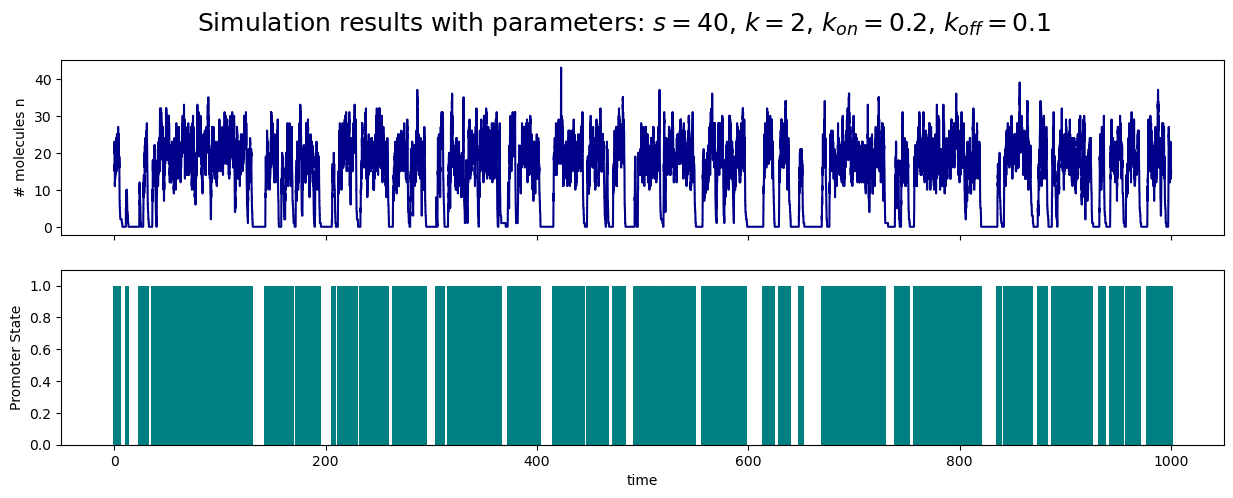

In [5]:
#Parameters for a SLOW RATE APPROXIMATION
s = 40 # Number of initiations per minute
k = 2 # Degradation rate, 1/k = 0.5 min
k_on  = 1/5 #Switching on rate, t_off = 1/k_on = 5 min
k_off = 1/10 #Switching off rate, t_on = 1/k_off = 10 min

parameters = [s, k, k_on, k_off]

# Run Gillespie simulation
n, g, t = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)

# Plot the results
plot_gillespie_telegraph(n, g, t, parameters="$s=40$, $k=2$, $k_{on}=0.2$, $k_{off}=0.1$")

### Constant stochastic expression
By setting $k_{off} \ll k_{on}$ or $k_{off} = 0$ and $s \simeq 10 \times k$ we obtain a classical stochastic expression. The average expression value is constant over time and equal to $\frac{s}{k}$ but very noisy around this value. This later gives a Poisson distribution around $\frac{s}{k}$.

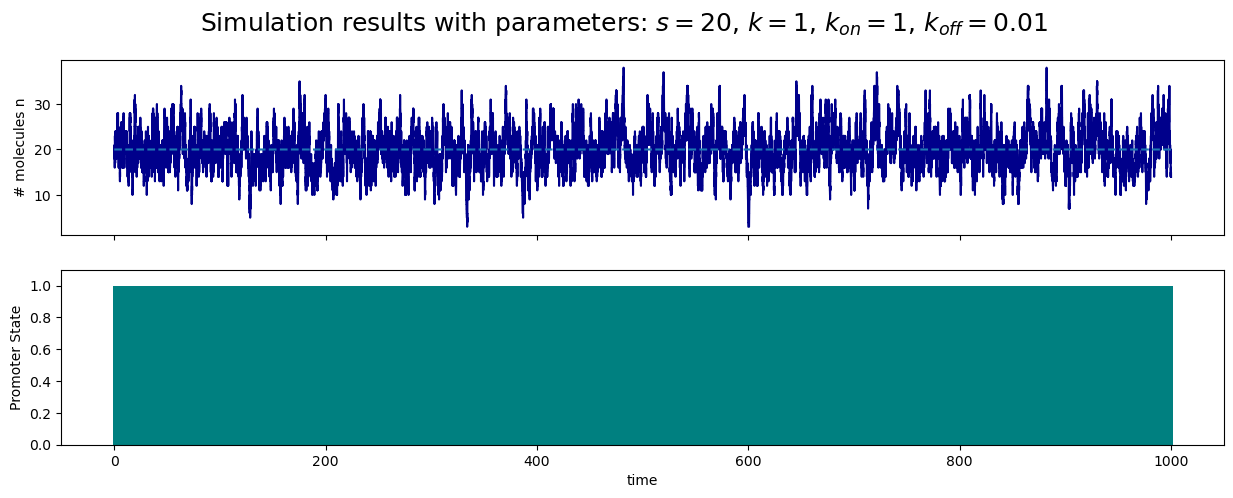

In [6]:
#Parameters for a CONSTANT STOCHASTIC EXPRESSION
s = 20 # Number of initiations per minute
k = 1 # Degradation rate, 1/k = 1 min
k_on  = 1 #Switching on rate, t_off = 1/k_on = 1 min
k_off = 1/100 #Switching off rate, t_on = 1/k_off = 100 min

parameters = [s, k, k_on, k_off]

# Run Gillespie simulation
n, g, t = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)

# Plot the results
plot_gillespie_telegraph(n, g, t, parameters="$s=20$, $k=1$, $k_{on}=1$, $k_{off}=0.01$", h_asymp=s/k)

### Simple birth-death process 
If $k_{off} \ll 1$ or $k_{off} = 0$ and $s \gg k$ then we always have synthesis so the population follows a simple birth-death process. We obtain the crassical increasing exponential. We verify that the final value is $\frac{s}{k}$ and that the half life is equal to $\frac{log 2}{k}$. We represent the half life with a red point and give its coordinates.

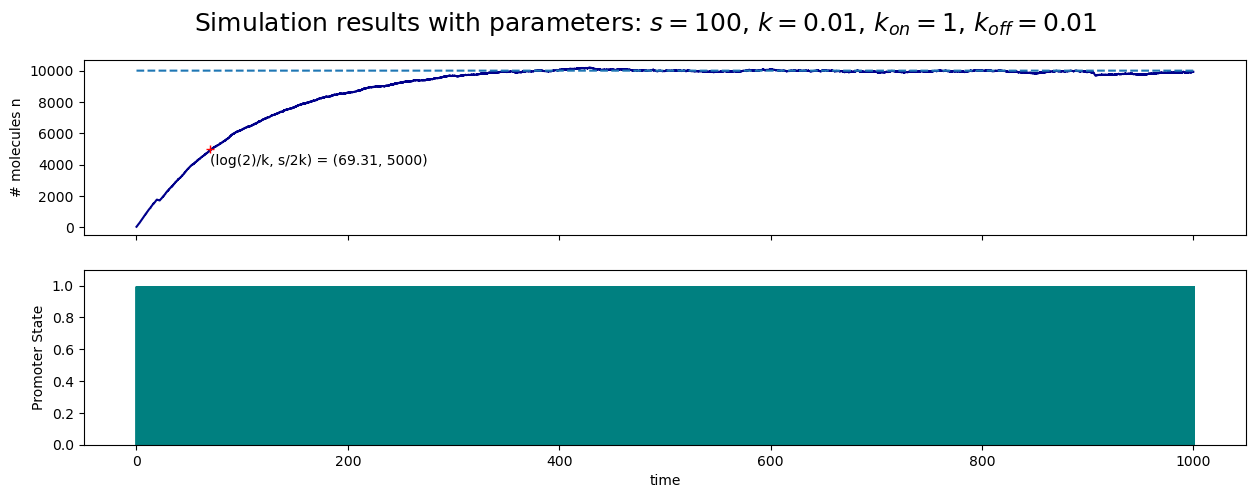

In [7]:
#Parameters for a SIMPLE BIRTH-DEATH PROCESS
s = 100 # Number of initiations per minute
k = 1/100 # Degradation rate, 1/k = 100 min
k_on  = 1 #Switching on rate, t_off = 1/k_on = 1 min
k_off = 1/100 #Switching off rate, t_on = 1/k_off = 100 min

parameters = [s, k, k_on, k_off]

# Run Gillespie simulation
n, g, t = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)

# Plot the results
plot_gillespie_telegraph(n, g, t, parameters="$s=100$, $k=0.01$, $k_{on}=1$, $k_{off}=0.01$", h_asymp=s/k, half_life=np.log(2)/k)

### Burst Approximation
If $k_{on} \ll k_{off}$ and $s \rightarrow +\infty$, the population follows the bursting approximation. Expression is occasionnaly on and for a short amount of time, but when it is, synthesis is very strong. Analysis of the distribution of such a population would give a negative binomial distribution.

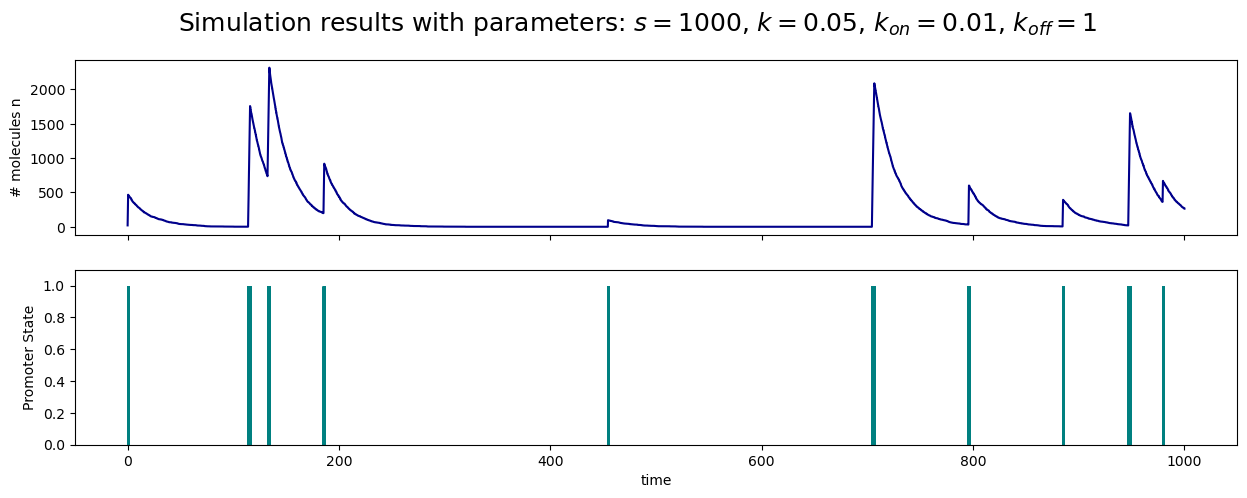

In [8]:
#Parameters for a BURST APPROXIMATION
s = 1000 # Number of initiations per minute
k = 1/20 # Degradation rate, 1/k = 20 min 
k_on  = 1/100 #Switching on rate, t_off = 1/k_on = 100 min
k_off = 1 #Switching off rate, t_on = 1/k_off = 1 min

parameters = [s, k, k_on, k_off]

# Run Gillespie simulation
n, g, t = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)

# Plot the results
plot_gillespie_telegraph(n, g, t, parameters="$s=1000$, $k=0.05$, $k_{on}=0.01$, $k_{off}=1$")

#### Question 2
1. Study the distribution of mRNA numbers generated by your simulation. Identify a parameter regime that results in a Poisson distribution of mRNA numbers. Show the empiral histogram and overlay an exact Poisson distribution and comment.

2. Find parameters where the mRNA distribution deviates from the Poisson (e.g. a Negative Binomial distribution). Discuss why these changes lead to a different distribution. 

3. For parameters that yield an approximate Poisson distribution, discuss how the parameters of the Telegraph model relate to the parameters of the Poisson distributions. 

4. Show a set of parameters that leads to a bimodal distribution of mRNA numbers.  


####  Helper functions for the Poisson and Negative Binomal distributions along with personnalized functions

In [26]:
# Poisson distribution
def Poisson(lam, counts):
    """
    Calculate the Poisson distribution probability for given counts.
    
    Parameters:
    lam: The average number of events (rate parameter).
    counts: Observed counts.

    Returns:
    np.array: Probabilities corresponding to the observed counts.

    Notes:
    - This function uses the log-form of the Poisson probability mass function.
    - The gammaln function is used for calculating the logarithm of the factorial term.

    """

    logp = counts * np.log(lam) - lam - gammaln(counts + 1)
    return np.exp(logp)

# Negative Binomial distribution
# This may not be needed for the exercise, but it is included for completeness
def convert_params(mu, theta):
    """

    Convert mean and dispersion parameters to the shape and probability parameters of the negative binomial distribution.
    
    Parameters:
    mu: Mean of the distribution.
    theta: Dispersion parameter.

    Returns:
    tuple: Shape parameter (r) and success probability (p) of the negative binomial distribution.

    Notes
    - This conversion is necessary because different parameterizations are used in different contexts.

    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

def pmf_nb(counts, mu, theta):
    """
    Compute the probability mass function of the negative binomial distribution for given counts.

    Parameters:
    counts: Observed counts.
    mu: Mean of the distribution.
    theta: Dispersion parameter.

    Returns:
    np.array: Probabilities corresponding to the observed counts.
    """


    return nbinom.pmf(counts, *convert_params(mu, theta))



# Helper functions of our own contribution

#Extension of the given poisson function into a distribution
def Poisson_distribution(lam, n_max = 30):
    return np.array([Poisson(lam, n) for n in range(n_max)])

# faster algorithm of the telegraph model thanks to approximation to a beta distribution
def fastTelegraph(param, size=1000):
    """ This function simulate @size samples from mRNA counts
    distributed according the stationnary distribution of
    the telegraph model, set up with parameters @param."""

    s, k, k_on, k_off=param
    r=np.random.beta(k_on/k,k_off/k,size)
    counts_per_cells=[np.random.poisson(s/k*r[i]) for i in range(size)]
    return counts_per_cells

# personnalized kroenecker delta function
def u(n_max=30):
    z=np.zeros(n_max)
    z[0]=1
    return z

### Distribution analysis

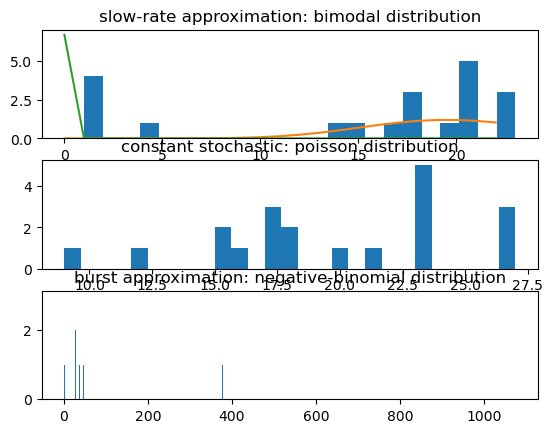

In [28]:
#setting the number of simulations that we want to perform
N_simulations = 20 #250

#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
n_0 = 20 # Initial count of species n

DT = 0.01 # Time interval for returning/printing the output
t_end = 100 #Total simulation time in minutes 400-1000

#Parameters and behaviors [behav_name, s, k, k_on, k_off]
slow_rate = ('slow-rate approximation: bimodal distribution', [40, 2, 1/5, 1/10])
constant = ('constant stochastic: poisson distribution', [20, 1, 1, 1/100])
#birth_death = ('simple birth-death', [100, 1/100, 1, 1/100])
burst = ('burst approximation: negative-binomial distribution', [1000, 1/20, 1/100, 1])

behaviors = [slow_rate, constant, burst]

# Run Gillespie simulations
n_mRNA = [[], [], [], []]
max_counts = []
fig, axes = plt.subplots(3, 1)
for i in range(3):
    for _ in range(N_simulations):
        n, _, _ = run_gillespie_telegraph(n_0, g_0, behaviors[i][1], t_end, DT)
        n_mRNA[i].append(n[-1])
    max_counts.append(max(n_mRNA[i]))
    axes[i].hist(n_mRNA[i], bins = max_counts[i]) #not sure if the bins is a right choice -> gives very small intervals in the third simulation
    axes[i].set_title(behaviors[i][0])

# adding theoritical distirbution plots to the graphs
k_on = slow_rate[1][2]
k_off = slow_rate[1][-1]
axes[0].plot(Poisson_distribution(s/k, max_counts[0]) * N_simulations * k_on / (k_on + k_off))
axes[0].plot(u(max_counts[0]) * N_simulations * k_off / (k_on + k_off))
k_on = constant[1][2]
k_off = constant[1][-1]
axes[1].plot(Poisson_distribution(s/k, max_counts[1]) * N_simulations * k_on / (k_on + k_off))


# Plot the results
plt.show()

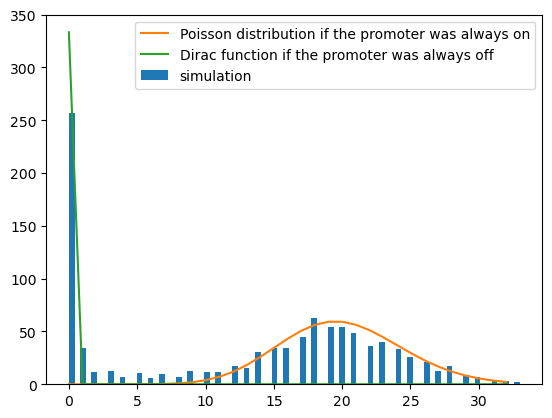

In [31]:
s,k,k_on,k_off = 40, 2, 0.2, 0.1
SIZE=1000
parameters=[s,k,k_on,k_off]
cell_counts = fastTelegraph(parameters)
max_count=max(cell_counts)
dist=Poisson_distribution(s/k,max_count)
plt.hist(cell_counts,bins=80)
plt.plot(dist*SIZE*k_on/(k_on+k_off))
plt.plot(u(max_count)*SIZE*k_off/(k_on+k_off))
plt.legend(['Poisson distribution if the promoter was always on', 'Dirac function if the promoter was always off','simulation',])
plt.show()

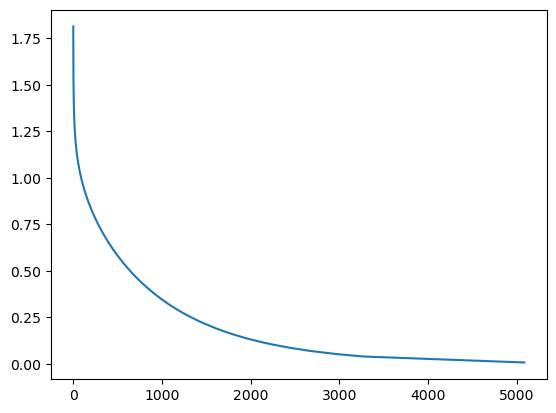

In [57]:
parameters = [1000, 1/20, 1/100, 1]
cell_counts = fastTelegraph(parameters)
ordered = cell_counts.copy()
ordered.sort()
cdf = [SIZE * pmf_nb(count, 1000, 0.9) for count in ordered]
#plt.hist(cell_counts, bins = 30)
plt.plot(ordered, cdf)
plt.show()

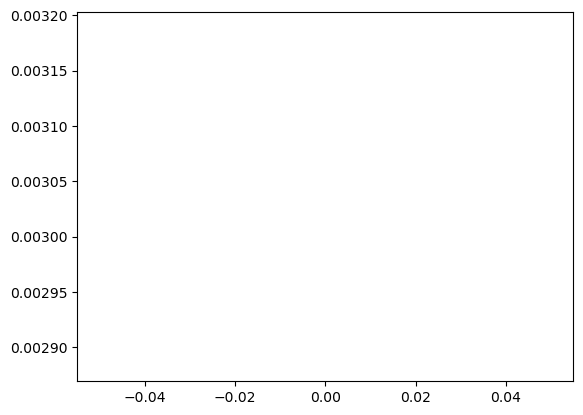

In [40]:
plt.plot(pmf_nb(100, 150, 0.8))
plt.show()